In [1]:
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import torch
torch.set_grad_enabled(False)
import torchmetrics
import torchmetrics.image
import torchvision
import wandb
wandb.init(mode="disabled", config={"device": "cuda", "data": {"noise_level": 0.05, "img_size": [175,175]}, "training": {"grad_batch_size": 16}})

from fidelity.models.simple_descent import SimpleDescent

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [2]:
def show(x: torch.Tensor) -> None:
    _ = plt.imshow((torch.clamp(x[0].cpu().detach().permute(1,2,0), 0.0, 1.0).numpy()*255.0).astype(np.uint8), cmap="gray")
    plt.show()

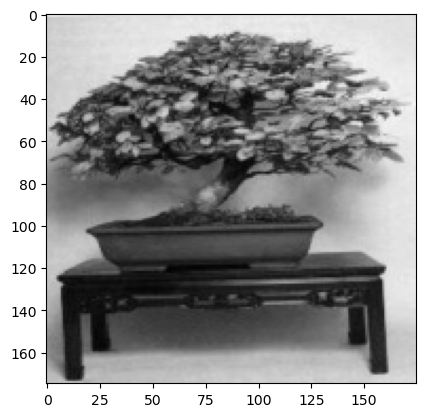

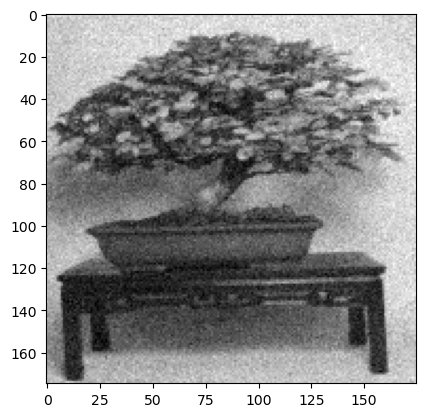

MSE:  0.002505006268620491
PSNR: 26.011981964111328
SSIM: 0.6357300281524658
FID:  231.2093505859375


In [3]:
import warnings


dataset = torchvision.datasets.Caltech256("/data/datasets", transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Grayscale(),
    torchvision.transforms.Resize(wandb.config["data"]["img_size"], antialias=cast(str, True)),
    torchvision.transforms.CenterCrop(wandb.config["data"]["img_size"])
]))
u = torch.stack(list(map(lambda x: x[0], [dataset[2000+i] for i in range(wandb.config["training"]["grad_batch_size"])]))).to("cuda")
f = u+wandb.config["data"]["noise_level"]*torch.randn_like(u)
show(u)
show(f)
print(f"MSE:  {torchmetrics.functional.mean_squared_error(f, u).item()}")
print(f"PSNR: {torchmetrics.functional.peak_signal_noise_ratio(f, u, data_range=1.0, dim=(1,2,3)).item()}")
print(f"SSIM: {cast(torch.Tensor, torchmetrics.functional.structural_similarity_index_measure(f, u, data_range=1.0)).item()}")
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message="Metric `.*` will save all")
    fid = torchmetrics.image.FrechetInceptionDistance().to("cuda")  # type: ignore
    fid.update(torch.clamp(f*255.0, 0.0, 255.0).to(torch.uint8).repeat(1,3,1,1), real=True)
    fid.update(torch.clamp(u*255.0, 0.0, 255.0).to(torch.uint8).repeat(1,3,1,1), real=False)
    print(f"FID:  {fid.compute().item()}")

In [4]:
model = SimpleDescent(iterations=500, lr=1e-2, img_weight=1e0, regularizer="TV-iso", reg_weight=1e0, ks_weight=5e0, cv_weight=1e2).to("cuda")
old_forward = model.forward
model.forward = lambda x: old_forward(x, 10)  # type: ignore

KS: 1.408738    Cov: 0.122304    Img: 0.387145    Reg: 0.000316
KS: 1.039075    Cov: 0.070528    Img: 0.322486    Reg: 0.013087
KS: 0.894389    Cov: 0.042107    Img: 0.267390    Reg: 0.021135
KS: 0.790938    Cov: 0.028430    Img: 0.218225    Reg: 0.026203
KS: 0.692504    Cov: 0.022588    Img: 0.177596    Reg: 0.030300
KS: 0.596601    Cov: 0.019235    Img: 0.146671    Reg: 0.034269
KS: 0.506149    Cov: 0.016303    Img: 0.123996    Reg: 0.038664
KS: 0.420660    Cov: 0.014054    Img: 0.107151    Reg: 0.042888
KS: 0.348848    Cov: 0.012554    Img: 0.094417    Reg: 0.046439
KS: 0.295765    Cov: 0.011353    Img: 0.084873    Reg: 0.049418
KS: 0.255550    Cov: 0.010237    Img: 0.077833    Reg: 0.051710
KS: 0.217717    Cov: 0.009112    Img: 0.072517    Reg: 0.053492
KS: 0.181922    Cov: 0.008171    Img: 0.068230    Reg: 0.055156
KS: 0.150015    Cov: 0.007566    Img: 0.064558    Reg: 0.057073
KS: 0.120739    Cov: 0.007013    Img: 0.061482    Reg: 0.058887
KS: 0.095706    Cov: 0.006430    Img: 0.

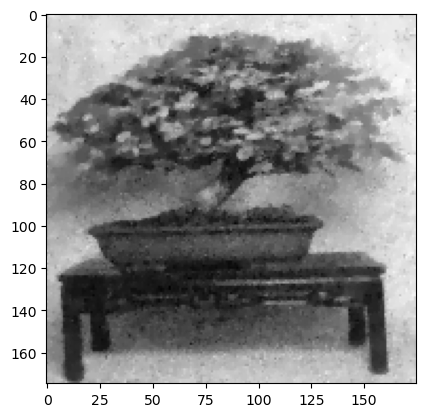

MSE:  0.05005906522274017
PSNR: 21.988147735595703
SSIM: 0.6187810301780701
FID:  259.6429138183594


In [5]:
u_hat = model(f).detach()
show(u_hat)
print(f"MSE:  {torchmetrics.functional.mean_squared_error(u_hat, u).item()}")
print(f"PSNR: {torchmetrics.functional.peak_signal_noise_ratio(u_hat, u, data_range=1.0, dim=(1,2,3)).item()}")
print(f"SSIM: {cast(torch.Tensor, torchmetrics.functional.structural_similarity_index_measure(u_hat, u, data_range=1.0)).item()}")
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message="Metric `.*` will save all")
    fid = torchmetrics.image.FrechetInceptionDistance().to("cuda")  # type: ignore
    fid.update(torch.clamp(u_hat*255.0, 0.0, 255.0).to(torch.uint8).repeat(1,3,1,1), real=True)
    fid.update(torch.clamp(u*255.0, 0.0, 255.0).to(torch.uint8).repeat(1,3,1,1), real=False)
    print(f"FID:  {fid.compute().item()}")

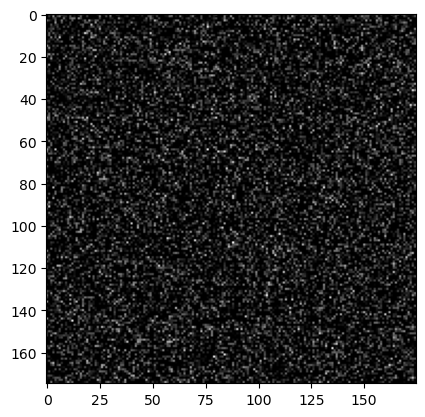

Mean: 2.4762959583313204e-05
Std:  0.05005008354783058


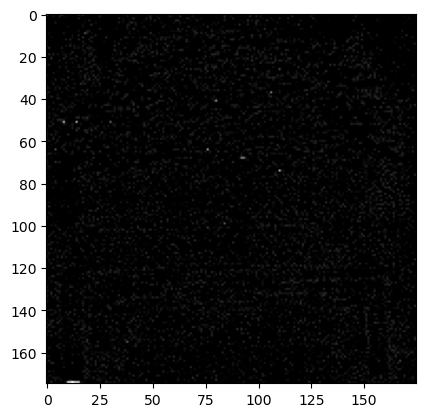

Mean: 0.04883327707648277
Std:  0.21970510482788086


In [6]:
show(f-u)
print(f"Mean: {(f-u).mean().item()}")
print(f"Std:  {(f-u).std().item()}")
show(f-u_hat)
print(f"Mean: {(f-u_hat).mean().item()}")
print(f"Std:  {(f-u_hat).std().item()}")